## Example 1: Cellular Response to Step Current

Mechanisms found:  True
Mechanisms already loaded from path: mod/.  Aborting.

Initiating HL23BN1 population...

Simulating ...
t = 100.0 ms
t = 200.0 ms
t = 300.0 ms
t = 400.0 ms
t = 500.0 ms
t = 600.0 ms
t = 700.0 ms
t = 800.0 ms
t = 900.0 ms
t = 1000.0 ms
t = 1100.0 ms
t = 1200.0 ms

Simulation complete ... plotting output


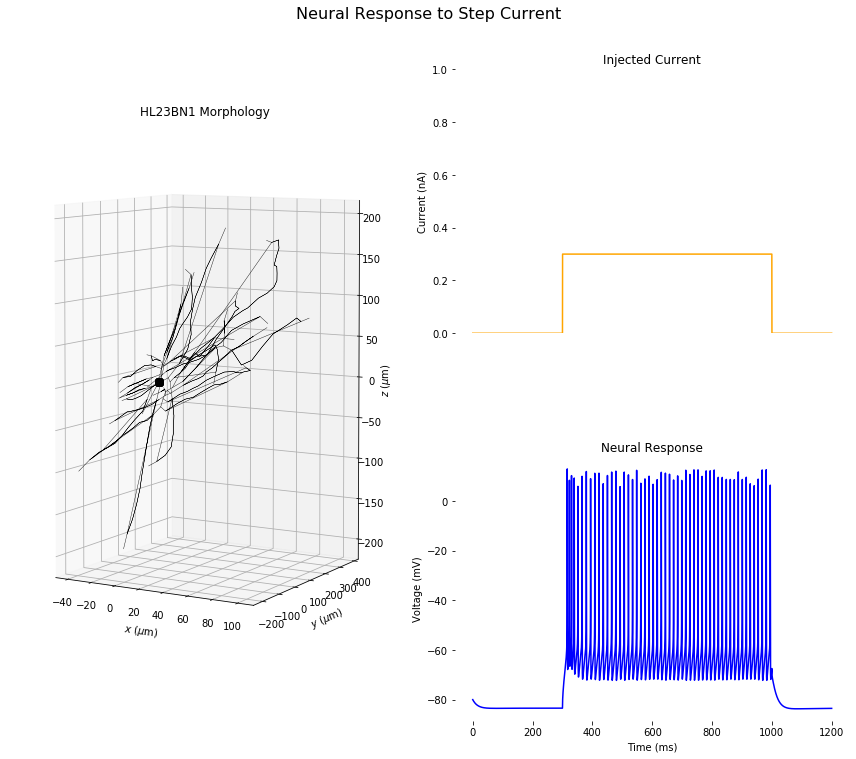

In [2]:
#===============================================================================================================
# 2020 Hay lab, Krembil Centre for Neuroinformatics, Summer School. Code available for educational purposes only
#===============================================================================================================
#===================================================================
# Import Modules and load relevant files
#===================================================================
import os
from os.path import join
import sys
import zipfile
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from matplotlib.collections import PolyCollection
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import scipy
from scipy import signal as ss
from scipy import stats as st
from mpi4py import MPI
import math
import neuron
from neuron import h, gui
import LFPy
from LFPy import NetworkCell, Network, Synapse, RecExtElectrode, StimIntElectrode
from net_params import *

print('Mechanisms found: ', os.path.isfile('mod/x86_64/special'))
neuron.h('forall delete_section()')
neuron.load_mechanisms('mod/')
h.load_file('net_functions.hoc')
h.load_file('models/biophys_HL23PN1.hoc')
h.load_file('models/biophys_HL23MN1.hoc')
h.load_file('models/biophys_HL23BN1.hoc')
h.load_file('models/biophys_HL23VN1.hoc')

#===================================================================
# Simulation Controls
#===================================================================

celltype = 'HL23BN1'
step_amp = .3

#===================================================================
# Parameters
#===================================================================

dt = 0.0625
tstart = 0.
t_stim = 300. 
tstop = 1200.
celsius = 34.
v_init = -80.

popargs = {'radius':1,
           'loc':0,
           'scale':1}

rotations = {'HL23PN1':{'x':1.57,'y':2.62},
             'HL23MN1':{'x':1.77,'y':2.77},
             'HL23BN1':{'x':1.26,'y':2.57},
             'HL23VN1':{'x':-1.57,'y':3.57}}

networkParams = {
    'dt' : dt,
    'tstart': tstart,
    'tstop' : tstop,
    'v_init' : v_init,
    'celsius' : celsius,
    'verbose' : False,
    'OUTPUTPATH': 'Circuit_output/E1/'}

morphpath = 'morphologies/' + celltype + '.swc'
templatepath = 'models/NeuronTemplate.hoc'
templatename = 'NeuronTemplate'

cellParams = {
    'morphology': morphpath,
    'templatefile': templatepath,
    'templatename': templatename,
    'templateargs': morphpath,
    'v_init': v_init, 
    'passive': False,
    'dt': dt,
    'tstart': 0.,
    'tstop': tstop,
    'nsegs_method': None,
    'pt3d': False,
    'delete_sections': False,
    'verbose': False}

if celltype in rotations.keys():
    rotation = rotations.get(celltype)

popParams = {
    'CWD': None,
    'CELLPATH': None,
    'Cell' : LFPy.NetworkCell,
    'POP_SIZE': 1,
    'name': celltype,
    'cell_args' : {**cellParams},
    'pop_args' : popargs,
    'rotation_args' : rotation}

#===================================================================
# Instantiate Network and Cell
#===================================================================

network = Network(**networkParams)

print('\n'+'Initiating '+celltype+' population...')
network.create_population(**popParams)

for cellind in range(0,len(network.populations[celltype].cells)):
    biophys = 'h.biophys_' + celltype + '(network.populations[\'' + celltype + '\'].cells[' + str(cellind) + '].template)'
    exec(biophys)
    
#===================================================================
# Add IClamp to Cell
#===================================================================

stimParams = {
    'idx' : 0,
    'record_current' : True,
    'pptype' : 'IClamp',
    'amp' : step_amp,
    'dur' : 700,
    'delay' : t_stim}

for cell in network.populations[celltype].cells:
    stimulus = LFPy.StimIntElectrode(cell, **stimParams)
    
#===================================================================
# Set Simulation Parameters and Simulate
#===================================================================

simargs = {'rec_imem': True,
           'rec_vmem': False,
           'rec_istim':True}

print('\n'+'Simulating ...')
SPIKES = network.simulate(**simargs)
print('\n'+'Simulation complete ... plotting output')

#===================================================================
# Plot Output
#===================================================================

fig = plt.figure(figsize=[12, 10])
tvec = np.arange(network.tstop / network.dt + 1) * network.dt

# Cell Morphology
ax = plt.subplot2grid((7, 4), (0, 0), rowspan=7, colspan=2, projection='3d')
ax.view_init(elev=5)
for i, cell in enumerate(network.populations[celltype].cells):
    for sec in neuron.h.allsec():
        idx = cell.get_idx(sec.name())
        ax.plot(np.r_[cell.xstart[idx], cell.xend[idx]],
                np.r_[cell.ystart[idx], cell.yend[idx]],
                np.r_[cell.zstart[idx], cell.zend[idx]], color='k', linewidth=0.4)
        ax.scatter(cell.somapos[0], cell.somapos[1], cell.somapos[2], c='k', marker='.', s=250)
    ax.set_xlabel('$x$ ($\mu$m)')
    ax.set_ylabel('$y$ ($\mu$m)')
    ax.set_zlabel('$z$ ($\mu$m)')
    ax.set_title(celltype+' Morphology')

# IClamp Current
    ax = plt.subplot2grid((7, 4), (0, 2), rowspan=3, colspan=2, frameon=False)
    for pointprocess in cell.pointprocesses:
        ax.plot(tvec, pointprocess.i, c='orange')
        ax.set_ylim([0,1])
        ax.set_ylabel('Current (nA)')
        ax.set_xticks([])
        ax.set_title('Injected Current')

# Somatic Voltage
    ax = plt.subplot2grid((7, 4), (4, 2), rowspan=3, colspan=2, frameon=False)
    ax.plot(tvec, cell.somav, c='blue')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Voltage (mV)')
    ax.set_title('Neural Response')

fig.suptitle('Neural Response to Step Current', y=1.05, fontsize=16)
fig.tight_layout()

####################################################################
# Clear space for next iteratino
####################################################################

network.pc.gid_clear()
electrode = None
syn = None
synapseModel = None
for population in network.populations.values():
    for cell in population.cells:
        cell = None
        population.cells = None
    population = None
    pop = None
    network = None
    neuron.h('forall delete_section()')